# 1. INITIALISATION

In [1]:
# Import necessary libraries and modules
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
# Check torch version
torch.__version__

# 2. LOADING & TRANSFORMING DATASET

In [3]:
# Creating transformer for training data as a series of steps
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Creating transformer for testing data as a series of steps - without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
# Loading the dataset from pytorch library
data_train = torchvision.datasets.CIFAR10(root="../data/raw", train=True, download=True, transform=transform_train)
data_test = torchvision.datasets.CIFAR10(root="../data/raw", train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Initialize data loaders
train_loader = torch.utils.data.DataLoader(data_train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=32, shuffle=False)

# 3. BUILDING CNN MODEL

In [8]:
class CNN(nn.Module):
    def __init__(self):
        
        super(CNN, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Define the pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # 8 * 8 * 6 is the flattened dimension after pooling
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 output units for 10 classes

    def forward(self, x):
        
        # Apply convolutional layers with ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten the output from the convolutional layers
        x = x.view(-1, 64 * 8 * 8)
        
        # Apply fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Apply the output layer with softmax activation
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [9]:
# Initialize the model
cnn = CNN()

# Define the loss function (cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer)
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

# 4. TRAINING CNN MODEL

In [10]:
# Initialize metrics function
def compute_metrics(outputs, labels):
     # Convert model outputs to predicted labels
    _, preds = torch.max(outputs, 1)
    
    # Convert labels and predictions to numpy arrays
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()
    
    # Calculate accuracy, F1-score, precision, and recall
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted', zero_division=1)
    recall = recall_score(labels, preds, average='weighted', zero_division=1)
    
    return accuracy, f1, precision, recall

In [12]:
# Number of epochs to train the model
num_epochs = 25

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model to the GPU
cnn.to(device)

# Set model to training mode
cnn.train()

# Lists to store training and validation metrics
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    
    running_loss = 0.0
    running_accuracy = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        
         # Move inputs and labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)     
        
        # Initialize parameter gradients
        optimizer.zero_grad()
        
        # Forward pass: compute model output
        outputs = cnn(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        
        # Calculate metrics
        accuracy, f1, precision, recall = compute_metrics(outputs, labels)
        running_accuracy += accuracy
        running_f1 += f1
        running_precision += precision
        running_recall += recall
    
    # Calculate average metrics for each epoch
    avg_loss = running_loss / len(train_loader)
    avg_accuracy = running_accuracy / len(train_loader)
    avg_f1 = running_f1 / len(train_loader)
    avg_precision = running_precision / len(train_loader)
    avg_recall = running_recall / len(train_loader)
    
    # Store training accuracy
    train_accuracies.append(avg_accuracy)
    
   # Set model to evaluation mode
    cnn.eval()
    
    # Initialize evaluation metrics
    eval_loss = 0.0
    eval_accuracy = 0.0
    eval_f1 = 0.0
    eval_precision = 0.0
    eval_recall = 0.0
    
    # Disable gradient computation for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            
            # Move inputs and labels to the GPU
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass: compute model output
            outputs = cnn(inputs)
            
            # Compute loss
            loss = criterion(outputs, labels)
            
            # Accumulate evaluation loss
            eval_loss += loss.item()
            
            # Calculate metrics
            accuracy, f1, precision, recall = compute_metrics(outputs, labels)
            eval_accuracy += accuracy
            eval_f1 += f1
            eval_precision += precision
            eval_recall += recall
    
    # Calculate average metrics for the evaluation set for each epoch
    avg_eval_loss = eval_loss / len(test_loader)
    avg_eval_accuracy = eval_accuracy / len(test_loader)
    avg_eval_f1 = eval_f1 / len(test_loader)
    avg_eval_precision = eval_precision / len(test_loader)
    avg_eval_recall = eval_recall / len(test_loader)
    
    # Store validation accuracy
    val_accuracies.append(avg_eval_accuracy)
    
    # Print average metrics for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'accuracy: {avg_accuracy:.4f} - f1_score: {avg_f1:.4f} - loss: {avg_loss:.4f} - '
          f'precision: {avg_precision:.4f} - recall: {avg_recall:.4f} - '
          f'val_accuracy: {avg_eval_accuracy:.4f} - val_f1_score: {avg_eval_f1:.4f} - val_loss: {avg_eval_loss:.4f} - '
          f'val_precision: {avg_eval_precision:.4f} - val_recall: {avg_eval_recall:.4f}')
        
    # Set model back to training mode
    cnn.train()

Epoch [1/25], accuracy: 0.4643 - f1_score: 0.4501 - loss: 1.4851 - precision: 0.5961 - recall: 0.4643 - val_accuracy: 0.5934 - val_f1_score: 0.5839 - val_loss: 1.1306 - val_precision: 0.6668 - val_recall: 0.5934
Epoch [2/25], accuracy: 0.6046 - f1_score: 0.6001 - loss: 1.1157 - precision: 0.6947 - recall: 0.6046 - val_accuracy: 0.6444 - val_f1_score: 0.6367 - val_loss: 1.0122 - val_precision: 0.7258 - val_recall: 0.6444
Epoch [3/25], accuracy: 0.6579 - f1_score: 0.6545 - loss: 0.9697 - precision: 0.7357 - recall: 0.6579 - val_accuracy: 0.6906 - val_f1_score: 0.6887 - val_loss: 0.8757 - val_precision: 0.7587 - val_recall: 0.6906
Epoch [4/25], accuracy: 0.6881 - f1_score: 0.6853 - loss: 0.8903 - precision: 0.7607 - recall: 0.6881 - val_accuracy: 0.7040 - val_f1_score: 0.7003 - val_loss: 0.8498 - val_precision: 0.7735 - val_recall: 0.7040
Epoch [5/25], accuracy: 0.7080 - f1_score: 0.7068 - loss: 0.8312 - precision: 0.7767 - recall: 0.7080 - val_accuracy: 0.7102 - val_f1_score: 0.7027 - va

# 5. PERFORMANCE ANALYSIS

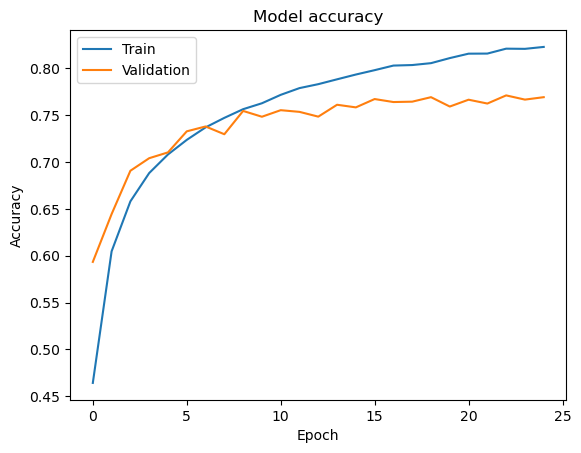

In [13]:
# Plot training & validation accuracy values
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()